In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything
from returns.result import Failure, Result, Success
from sklearn.pipeline import Pipeline

seed_everything(42, workers=True)

import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_model_cdf_grid,
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer


Seed set to 42


---

In [3]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [4]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

In [5]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - hidden_continuous_size (model-specific)
  - quantiles (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - future_forcing_projection_size (model-specific)
  - past_feature_projection_size (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - bias (model-specific)
  - bidirectional (model-specific)
  - bidirectional_fusion (model-specific)
  - future_hidden_size (model-specific)
  - future_layers (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)


In [6]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [7]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)
country_ids = [id for id in country_ids if id != "CA_15030"]

In [8]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [9]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [10]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [11]:
tft_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tft_hp["input_len"],
    output_length=tft_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tide_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tsmixer_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tsmixer_hp["input_len"],
    output_length=tsmixer_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

ealstm_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=ealstm_hp["input_len"],
    output_length=ealstm_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)


In [12]:
def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True):
    """
    Function to get the best checkpoint for a given model type
    """
    result = checkpoint_manager.get_checkpoint_path_to_load(
        base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
    )
    return result


def unwrap(checkpoint: Result) -> Path:
    """
    Function to unwrap the checkpoint result
    """
    if isinstance(checkpoint, Failure):
        print(f"Failed to load checkpoint: {checkpoint.failure()}")
        return None
    elif isinstance(checkpoint, Success):
        return checkpoint.unwrap()


pretrained_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_{COUNTRY.lower()}/checkpoints"
)

finetuned_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low-medium-hii_{COUNTRY.lower()}/checkpoints"
)

benchmark_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_{COUNTRY.lower()}/checkpoints"
)

In [13]:
tft_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)


tsmixer_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
tsmixer_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

ealstm_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tsmixer_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

print(
    f"Pretrained checkpoints: {tide_pretrained_checkpoint}, {ealstm_pretrained_checkpoint}, {tsmixer_pretrained_checkpoint}, {tft_pretrained_checkpoint}"
)
print(
    f"Finetuned checkpoints: {tide_finetuned_checkpoint}, {ealstm_finetuned_checkpoint}, {tsmixer_finetuned_checkpoint}, {tft_finetuned_checkpoint}"
)
print(
    f"Benchmark checkpoints: {tide_benchmark_checkpoint}, {ealstm_benchmark_checkpoint}, {tsmixer_benchmark_checkpoint}, {tft_benchmark_checkpoint}"
)

Pretrained checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=75-val_loss=0.0446.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=43-val_loss=0.0924.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=41-val_loss=0.0934.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tft/run_0/attempt_0/tft-run0-attempt_0-epoch=154-val_loss=0.0380.ckpt
Finetuned checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low-medium-hii_tajikistan/checkpoints/tide/run_3/attempt_0/tide-run3-attempt_0-epoch=13-val_loss=0.0298.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/

In [14]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    # "tide_benchmark": (tide_benchmark_model, tide_data_module),
    # "tide_pretrained": (tide_pretrained_model, tide_data_module),
    # "tide_finetuned": (tide_finetuned_model, tide_data_module),
    # "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    # "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    # "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    # "tft_benchmark": (tft_benchmark_model, tft_data_module),
    # "tft_pretrained": (tft_pretrained_model, tft_data_module),
    # "tft_finetuned": (tft_finetuned_model, tft_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1, "deterministic": True, "benchmark": False},
)

In [15]:
# Run evaluation
results = evaluator.test_models()

2025-06-11 10:02:33,649 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: ealstm_benchmark
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-11 10:02:33,666 - hydro_forecasting.data.in_memory_datamodule - INFO - Starting data preparation...
2025-06-11 10:02:33,666 - hydro_forecasting.data.in_memory_datamodule - INFO - Generated Run UUID for current config: e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
2025-06-11 10:02:33,667 - hydro_forecasting.data.in_memory_datamodule - INFO - Checking for existing processed data at: /Users/cooper/Desktop/hydro-forec

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2415339946746826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-11 10:02:46,327 - hydro_forecasting.model_evaluation.evaluators - INFO - Successfully tested model: ealstm_benchmark
2025-06-11 10:02:46,328 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: ealstm_pretrained
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-11 10:02:46,340 - hydro_forecasting.data.in_memory_datamodule - INFO - Data preparation has already run.
2025-06-11 10:02:46,348 - hydro_forecasting.data.in_memory_datamodule - INFO - Loading test data for 16 basins...
2025-06-11 10:02:46,367 - hydro_forecasting.data.in_memory_data

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5960626602172852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-11 10:02:58,282 - hydro_forecasting.model_evaluation.evaluators - INFO - Successfully tested model: ealstm_pretrained
2025-06-11 10:02:58,283 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: ealstm_finetuned
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-11 10:02:58,307 - hydro_forecasting.data.in_memory_datamodule - INFO - Data preparation has already run.
2025-06-11 10:02:58,337 - hydro_forecasting.data.in_memory_datamodule - INFO - Loading test data for 16 basins...
2025-06-11 10:02:58,365 - hydro_forecasting.data.in_memory_data

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.554530143737793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-11 10:03:10,753 - hydro_forecasting.model_evaluation.evaluators - INFO - Successfully tested model: ealstm_finetuned
2025-06-11 10:03:10,753 - hydro_forecasting.model_evaluation.evaluators - INFO - Testing model: dummy
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-11 10:03:10,765 - hydro_forecasting.data.in_memory_datamodule - INFO - Data preparation has already run.
2025-06-11 10:03:10,771 - hydro_forecasting.data.in_memory_datamodule - INFO - Loading test data for 16 basins...
2025-06-11 10:03:10,793 - hydro_forecasting.data.in_memory_datamodule - INF

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05137426033616066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2025-06-11 10:03:17,336 - hydro_forecasting.model_evaluation.evaluators - INFO - Successfully tested model: dummy


In [16]:
results["dummy"]["predictions_df"].head(30)

,horizon,observed,predicted,date,gauge_id
0,1,0.52,0.54,2019-06-04,CA_16205
1,2,0.74,0.54,2019-06-05,CA_16205
2,3,0.52,0.54,2019-06-06,CA_16205
3,4,0.52,0.54,2019-06-07,CA_16205
4,5,0.55,0.54,2019-06-08,CA_16205
5,6,0.55,0.54,2019-06-09,CA_16205
6,7,0.56,0.54,2019-06-10,CA_16205
7,8,0.62,0.54,2019-06-11,CA_16205
8,9,0.62,0.54,2019-06-12,CA_16205
9,10,0.64,0.54,2019-06-13,CA_16205


In [18]:
# from typing import Any


# def filter_growing_season_polars(eval_results: dict[str, Any]) -> dict[str, Any]:
#     """
#     Filter evaluation results to include only data from the growing season (April to October), using Polars.

#     Args:
#         eval_results: dictionary containing evaluation results with a 'df' key,
#                       where 'df' is a Polars DataFrame.

#     Returns:
#         dictionary with filtered Polars DataFrame and original metrics.
#     """
#     filtered_results = eval_results.copy()

#     df = eval_results["df"].clone()

#     if "date" not in df.columns:
#         raise ValueError("DataFrame must contain a 'date' column.")

#     growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() <= 9))

#     growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10))

#     filtered_results["df"] = growing_season_df

#     return filtered_results


# def process_seasonal_results_polars(
#     results: dict[str, Any],
#     evaluator: Any,  # Replace Any with the actual type of TSForecastEvaluator if available
#     model_keys: list[str] = None,
# ) -> dict[str, Any]:
#     """
#     Process specified model results to get seasonal metrics using Polars DataFrames.

#     Args:
#         results: dictionary containing results for all models.
#         evaluator: Evaluator object with _calculate_overall_metrics and
#                    _calculate_basin_metrics methods that can handle Polars DataFrames.
#                    (As per evaluators.py, these methods already use Polars)
#         model_keys: list of model keys to process. If None, process all keys in results.

#     Returns:
#         dictionary with seasonal results for the specified models.
#     """
#     seasonal_results = {}

#     if model_keys is None:
#         model_keys = list(results.keys())

#     # Process each model
#     for key in model_keys:
#         if key not in results:
#             print(f"Warning: Model key '{key}' not found in results. Skipping.")
#             continue

#         # Filter for growing season using the Polars version
#         seasonal_model_results = filter_growing_season_polars(results[key])

#         seasonal_model_results["metrics"] = evaluator._calculate_overall_metrics(seasonal_model_results["df"])
#         seasonal_model_results["basin_metrics"] = evaluator._calculate_basin_metrics(seasonal_model_results["df"])

#         # Store in results dictionary
#         seasonal_results[key] = seasonal_model_results

#     return seasonal_results


# seasonal_results = process_seasonal_results_polars(results, evaluator, model_keys=list(models_and_datamodules.keys()))

In [19]:
sns.set_context(context="paper", font_scale=1.3)

In [25]:
# results["ealstm_benchmark"]["metrics_by_gauge"]

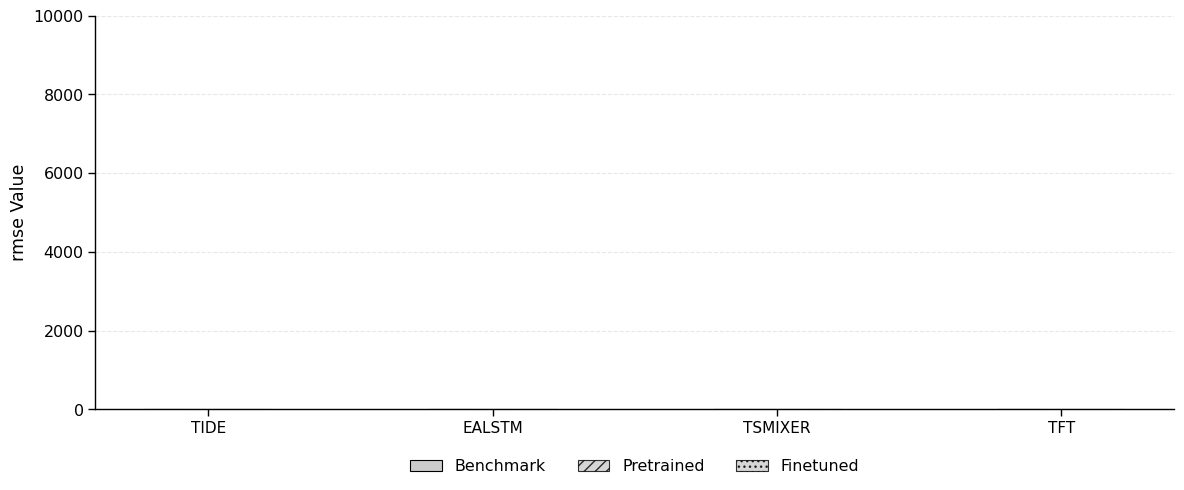

In [27]:
fig, ax = plot_horizon_performance_bars(
    results,
    horizon=1,
    metric="rmse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "pretrained", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 5),
    with_whiskers=False,
    positive_is_better=True,
    dummy_model="dummy",
)
ax.set_ylim(0, 10000)
sns.despine()
plt.show()


In [ ]:
fig, ax = plot_basin_performance_scatter(
    seasonal_results,
    benchmark_pattern="pretrained",
    challenger_pattern="finetuned",
    horizon=10,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    metric="NSE",
    figsize=(10, 6),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=False,
)
sns.despine()
plt.show()

In [ ]:
fig, axes = plot_model_cdf_grid(
    seasonal_results,
    horizons=[1, 5, 10],
    metric="NSE",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(10, 8),
)
sns.despine()
plt.savefig(f"/Users/cooper/Desktop/hydro-forecasting/images/preliminary_results/cdf_grid_{COUNTRY}.png", dpi=300, bbox_inches="tight")

plt.show()

# DEBUG

In [ ]:
test_loader = ealstm_data_module.test_dataloader()

for batch_idx, batch in enumerate(test_loader):
    print(f"Batch {batch_idx}:")
    print(f"X shape: {batch['X'].shape}")
    print(f"y shape: {batch['y'].shape}")

    # Look at the first sample in detail
    print("\nFirst sample analysis:")
    print(f"X[0] shape: {batch['X'][0].shape}")  # [input_len, input_size]
    print(f"y[0] shape: {batch['y'][0].shape}")  # [output_len]

    # Show the actual values
    print("\nFirst sample X (all timesteps, first feature):")
    print(batch["X"][0, :, 0])  # First feature across all input timesteps

    print("\nFirst sample X (last timestep, all features):")
    print(batch["X"][0, -1, :])  # All features at the last timestep

    print("\nFirst sample y (target values to predict):")
    print(batch["y"][0])  # Target values for forecast horizon

    print("\nWhat dummy model extracts:")
    last_target_value = batch["X"][0, -1, 0].item()  # What dummy model thinks is last target
    print(f"Last value of first feature: {last_target_value}")

    print(f"\nGauge ID: {batch['gauge_id'][0]}")

    # Stop after first batch for debugging
    break

In [ ]:
print("Target variable:", ealstm_data_module.target)
print("Input features ordered:", ealstm_data_module.input_features_ordered_for_X)
print("Forcing features:", ealstm_data_module.forcing_features)